In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold

import tensorflow as tf

In [18]:
# home_df = pd.read_csv('../Pt3_Data_processing/home_structured_ewm16.csv')
# away_df = pd.read_csv('../Pt3_Data_processing/away_structured_ewm16.csv')

df = pd.read_csv('../Pt3_Data_processing/home_structured_ewm18_nonadj.csv')
df.sort_values(by='h_pg_date', inplace=True)

# Turning IDS into categorical variables
for col in df:
    if 'id' in col:
        df[col]=df[col].astype('category')
    
# Turning age into integers        
for col in [col for col in df if 'age' in col]:
    df[col] = df[col].apply(lambda x: int(x.replace(' days 00:00:00.000000000','')))
    
df.drop_duplicates(inplace=True)

name_id_remove = [col for col in df if any(c in col for c in ['_player_id','_name', '_team'])]

modelling_columns = ['h_pg_outcome', 'h_pg_difference', 'h_pg_type', 'h_pg_location'] + \
[col for col in df.loc[:,'h_pg_age_days':] if \
                     col not in name_id_remove]

X = df[modelling_columns].copy()
# X.fillna(value=0, inplace=True)

print('COVID\n',X['h_pg_outcome'][X['a_pg_date']>'2020-03-30'].value_counts(normalize=True))
print('\n2018-\n',X['h_pg_outcome'][X['a_pg_date']>'2018-08-30'].value_counts(normalize=True))
print('\n-2018\n',X['h_pg_outcome'][X['a_pg_date']<'2018-08-30'].value_counts(normalize=True))
print('\n2019-\n',X['h_pg_outcome'][X['a_pg_date']>'2019-08-30'].value_counts(normalize=True))
print('\n-2019\n',X['h_pg_outcome'][X['a_pg_date']<'2019-08-30'].value_counts(normalize=True))

X[X['a_pg_date']>'2017-08-30'].shape[0], X[X['a_pg_date']<'2017-08-30'].shape[0]

# REMOVING FIRST YEAR OF GAMES AND POST-COVID 
# (GAMES NOT PLAYED ON HOME COURTS, DATA CONSTRUCTION WOULD CAUSE ISSUES)
X.drop(X[X['a_pg_date']<'2001-08-30'].index, inplace=True)
X.drop(X[X['a_pg_date']>'2020-03-30'].index, inplace=True)

print('\nBASELINE FOR TOTAL DATASET :\n',X['h_pg_outcome'].value_counts(normalize=True))

print('\nDF SHAPE :\n',X.shape)

# for i in range(16):
# #     PREFIX FOR NEW COLUMN NAMES
#     prefix = [col for col in X if 'fgm' in col][i][:4]
# #     FG%
#     X[f'{prefix}_fgpct'] = X[[col for col in X if 'fgm' in col][i]] / \
#     X[[col for col in X if 'fga' in col][i]]
# #     FG3%
#     X[f'{prefix[:-4]}_fg3pct'] = X[[col for col in X if 'fg3m' in col][i]] / \
#     X[[col for col in X if 'fg3a' in col][i]]
# #     FT%
#     X[f'{prefix[:-4]}_ftpct'] = X[[col for col in X if 'ftm' in col][i]] / \
#     X[[col for col in X if 'fta' in col][i]]
# #     JOHN HOLLINGER GAMESCORE
#     X[f'{prefix}_gs'] = X[f'{prefix}_ewm_pts'] + .4*X[[col for col in X if 'fgm' in col][i]] - \
#     .7*X[[col for col in X if 'fga' in col][i]] - .4*(X[[col for col in X if 'fta' in col][i]] - \
#                                                      X[[col for col in X if 'ftm' in col][i]]) + \
#     .7*X[[col for col in X if 'oreb' in col][i]] + .3*X[[col for col in X if 'dreb' in col][i]] + \
#     X[[col for col in X if '_stl' in col][i]] + .7*X[[col for col in X if 'ewm_ast' in col][i]] + \
#     .7*X[[col for col in X if 'ewm_blk' in col][i]] - .4*X[[col for col in X if 'ewm_pf' in col][i]] - \
#     X[[col for col in X if 'ewm_to' in col][i]]
    

COVID
 1    0.533333
0    0.466667
Name: h_pg_outcome, dtype: float64

2018-
 1    0.571667
0    0.428333
Name: h_pg_outcome, dtype: float64

-2018
 1    0.600805
0    0.399195
Name: h_pg_outcome, dtype: float64

2019-
 1    0.549639
0    0.450361
Name: h_pg_outcome, dtype: float64

-2019
 1    0.600271
0    0.399729
Name: h_pg_outcome, dtype: float64

BASELINE FOR TOTAL DATASET :
 1    0.597252
0    0.402748
Name: h_pg_outcome, dtype: float64

DF SHAPE :
 (23002, 539)


In [19]:
X.drop(columns=['a_pg_season_id', 'a_pg_location', 'a_pg_type',
       'a_pg_outcome', 'a_pg_difference', 'a_pg_game_id'], inplace=True)

X.fillna(0, inplace=True)


X_train = X[X['a_pg_date']<'2017-08-30'].copy()
X_test = X[X['a_pg_date']>'2017-08-30'].copy()

X_train.drop(columns='a_pg_date', inplace=True)
X_test.drop(columns='a_pg_date', inplace=True)



yC_train = X_train.pop('h_pg_outcome')
yC_test = X_test.pop('h_pg_outcome')

yR_train = X_train.pop('h_pg_difference')
yR_test = X_test.pop('h_pg_difference')

columns = X_train.columns

In [7]:
# poly = PolynomialFeatures()
# poly.fit(X_train)
# X_train = pd.DataFrame(poly.transform(X_train),
#                        columns=poly.get_feature_names([c for c in X_train if c!=0]))
# X_test = pd.DataFrame(poly.transform(X_test),
#                        columns=poly.get_feature_names([c for c in X_train if c!=0]))

# power = PowerTransformer()
# X_train = pd.DataFrame(power.fit_transform(X_train),
#                        columns=X_train.columns)
# X_test = pd.DataFrame(power.transform(X_test),
#                       columns=X_train.columns)

In [22]:
kf = KFold(shuffle=True, random_state=42)

rfc = RandomForestClassifier(n_estimators=500, max_features='sqrt')

rfc_params = {'criterion' : ['entropy'],
              'max_depth' : [13,14,15],
              'min_impurity_decrease' : [0, .001, .01]}

rfc_grid = GridSearchCV(rfc, rfc_params, n_jobs=2, verbose=3, cv=kf)

rfc_grid.fit(X_train, yC_train)

print('Train score   : ', rfc_grid.score(X_train, yC_train))
print('Test score    : ', rfc_grid.score(X_test, yC_test))
print('Mean CVscore. : ', rfc_grid.best_score_)
print(rfc_grid.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed: 21.7min
[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed: 33.7min finished


Train score   :  0.973581614855853
Test score    :  0.6587799315849487
Mean CVscore. :  0.6662557040911545
{'criterion': 'entropy', 'max_depth': 13, 'min_impurity_decrease': 0}


In [21]:
from sklearn.ensemble import GradientBoostingClassifier

kf = KFold(shuffle=True, random_state=42)

gfc = GradientBoostingClassifier(n_estimators=400, max_features='sqrt')

gfc_params = {'max_depth' : [3,4,5,6,7], 'learning_rate':np.linspace(.025,.1,4)}

gfc_grid = GridSearchCV(gfc, gfc_params, n_jobs=2, verbose=3, cv=kf)

gfc_grid.fit(X_train, yC_train)

print('Train score   : ', gfc_grid.score(X_train, yC_train))
print('Test score    : ', gfc_grid.score(X_test, yC_test))
print('Mean CVscore. : ', gfc_grid.best_score_)
print(gfc_grid.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed: 14.4min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed: 53.8min finished


Train score   :  0.7831640504770698
Test score    :  0.6576396807297605
Mean CVscore. :  0.668461700524177
{'learning_rate': 0.025, 'max_depth': 5}


In [6]:
import joblib
# joblib.dump(gfc_grid, 'gfc_polynomials_66.jlib')
# joblib.dump(rfc_grid, 'rfc_polynomials_66.jlib')

In [7]:
# import joblib
gfc_load = joblib.load('gfc_polynomials_66.jlib')
rfc_load = joblib.load('rfc_polynomials_66.jlib')

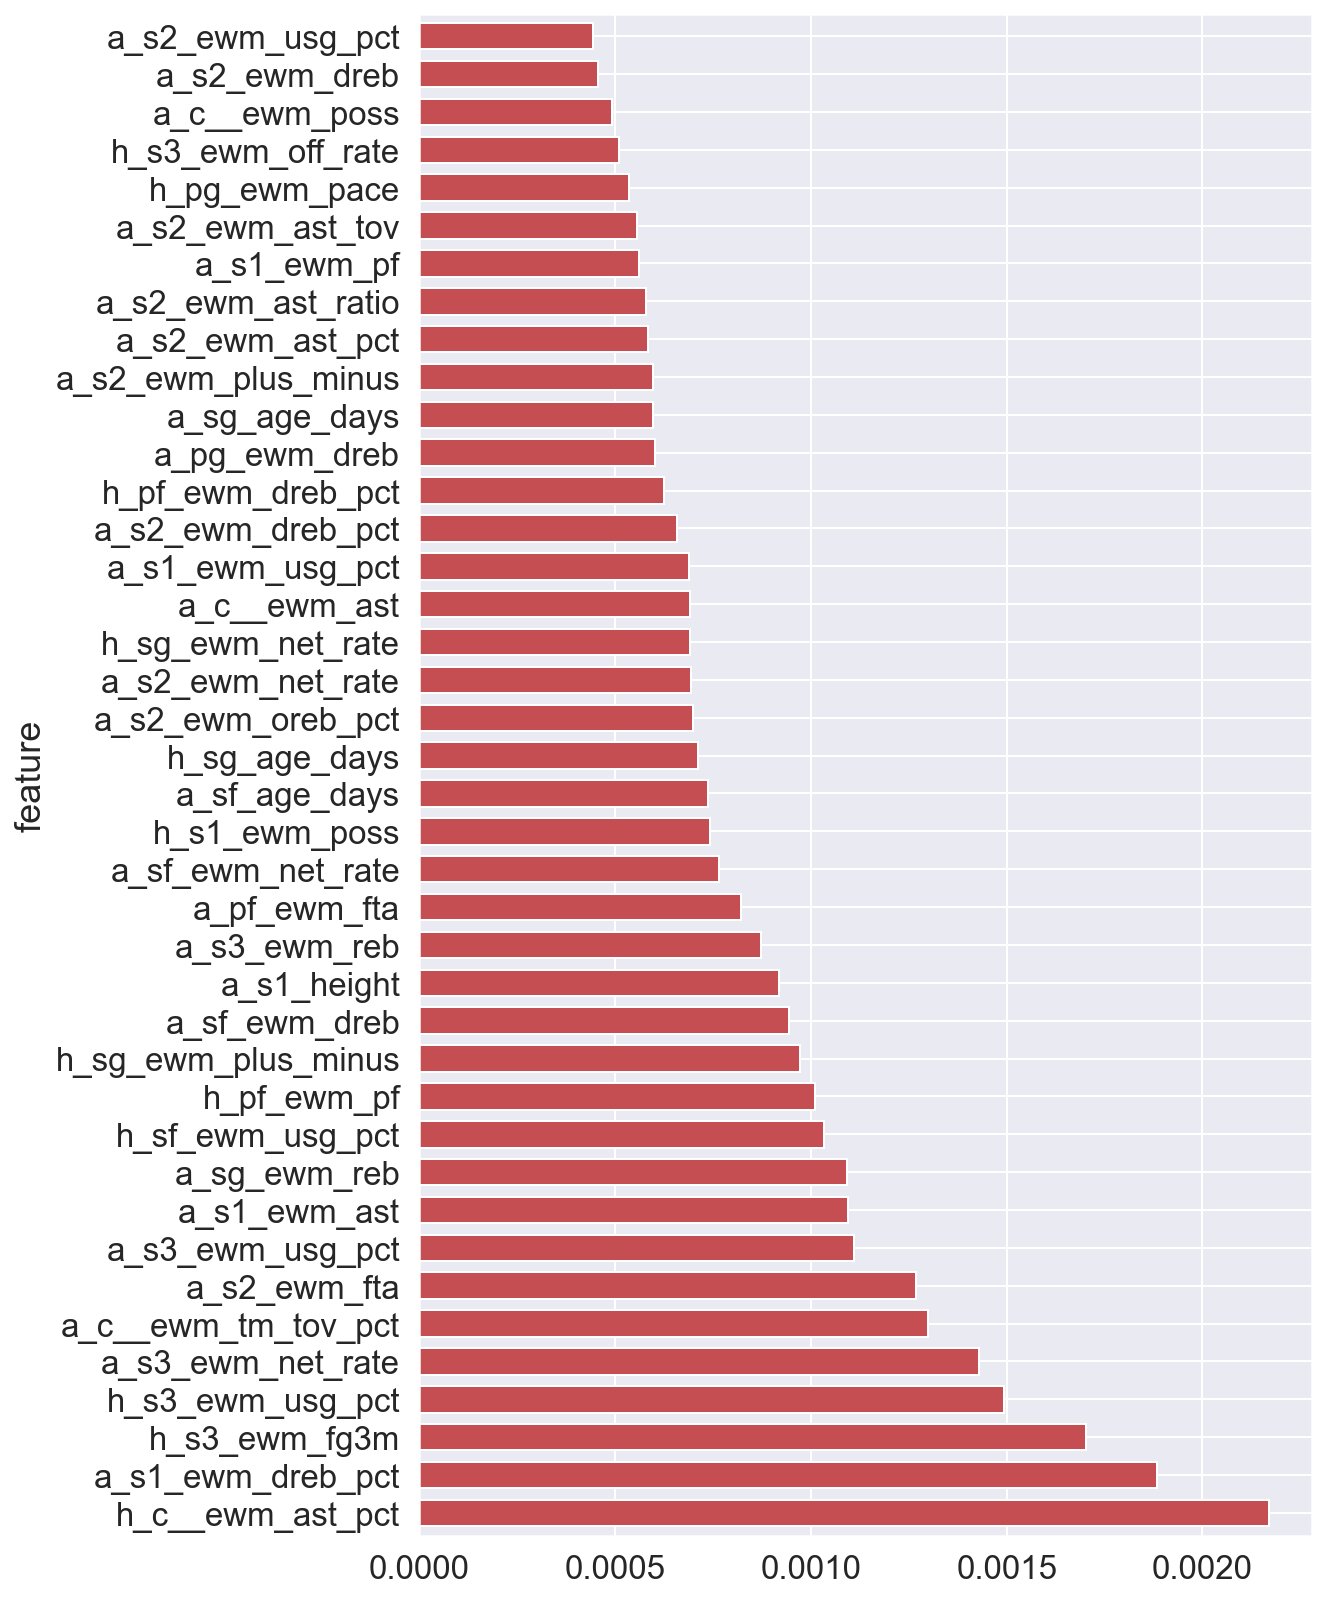

In [28]:
feat_importance = pd.DataFrame(zip(X_train.columns,
                 rfc_load.best_estimator_.feature_importances_))
feat_importance.columns = ['feature', 'feature_importances']
feat_importance.set_index('feature', inplace=True)


feat_importance.sort_values(by='feature_importances',
                        ascending=False).head(40)['feature_importances'].plot(kind='barh',
                                                                      figsize=(8,14),
                                                                      color='r',
                                                                      width=.7);

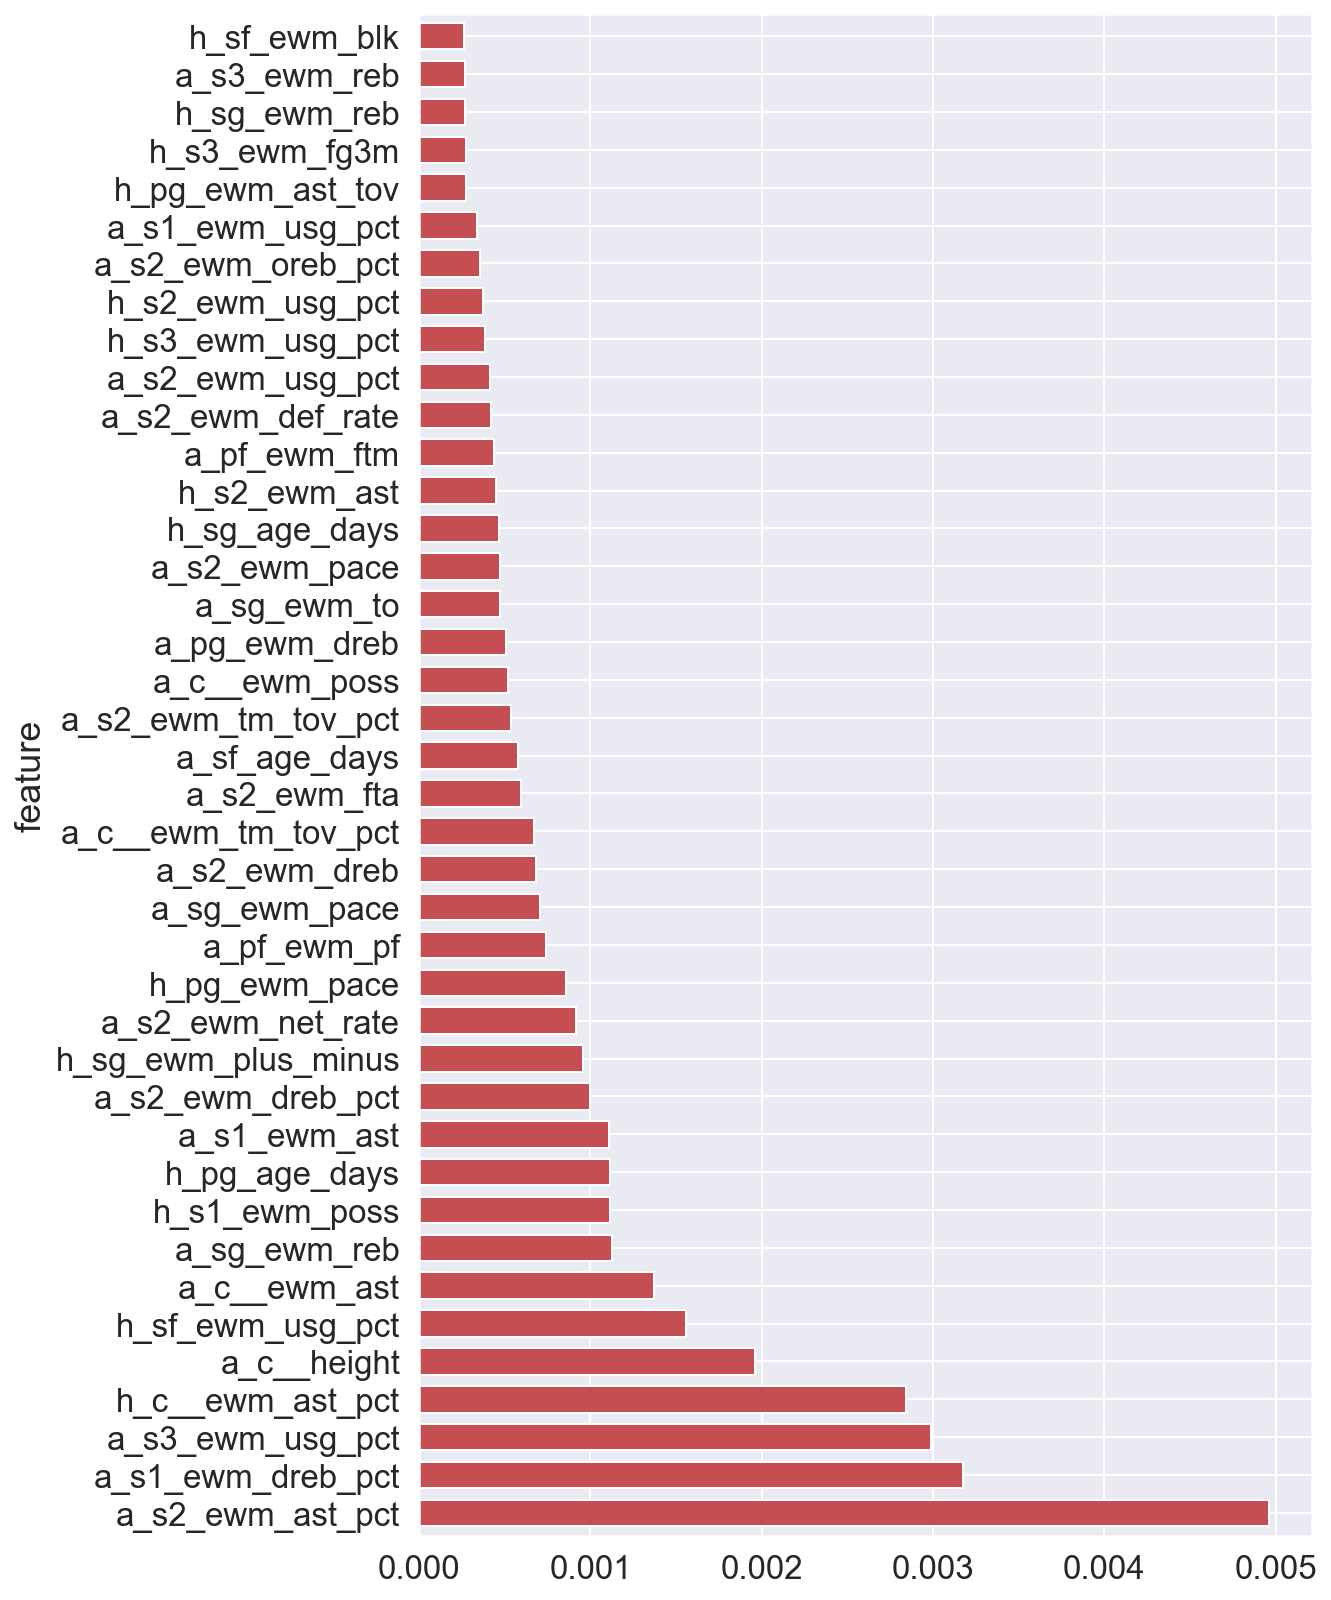

In [27]:
feat_importance = pd.DataFrame(zip(X_train.columns,
                 gfc_load.best_estimator_.feature_importances_))
feat_importance.columns = ['feature', 'feature_importances']
feat_importance.set_index('feature', inplace=True)


feat_importance.sort_values(by='feature_importances',
                        ascending=False).head(40)['feature_importances'].plot(kind='barh',
                                                                      figsize=(8,14),
                                                                      color='r',
                                                                      width=.7);

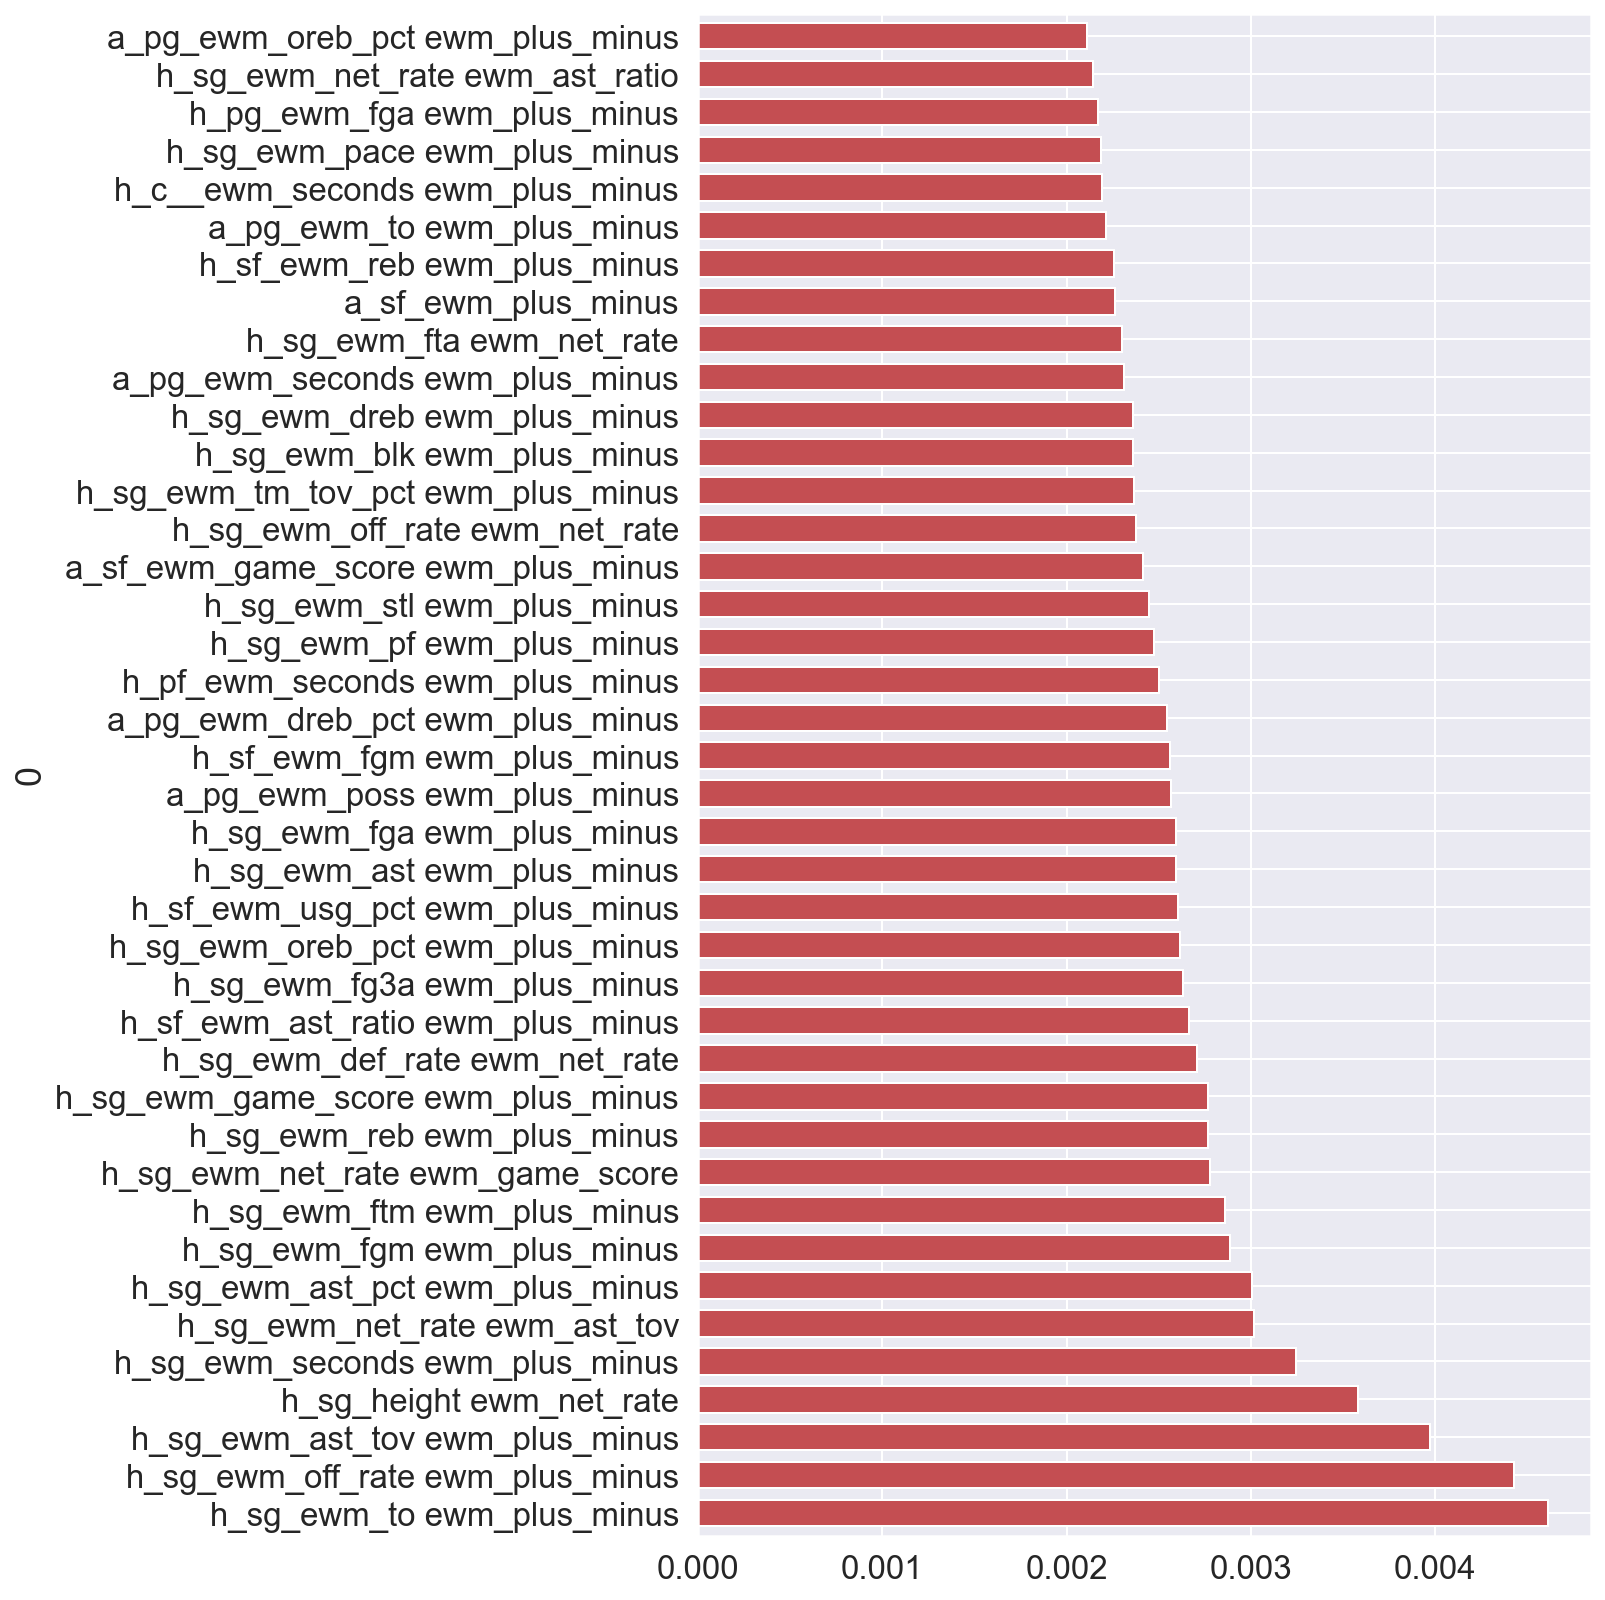

In [14]:


best_coeffs = pd.DataFrame(zip(X_train.columns,
                 rfc_load.best_estimator_.feature_importances_)).set_index(0)

best_coeffs.columns = ['feature importances']

best_coeffs.sort_values(by='feature importances',
                        ascending=False).head(40)['feature importances'].plot(kind='barh',
                                                                      figsize=(8,14),
                                                                      color='r',
                                                                      width=.7);

395    0.657925
396    0.658210
397    0.658780
398    0.658210
399    0.657640
dtype: float64


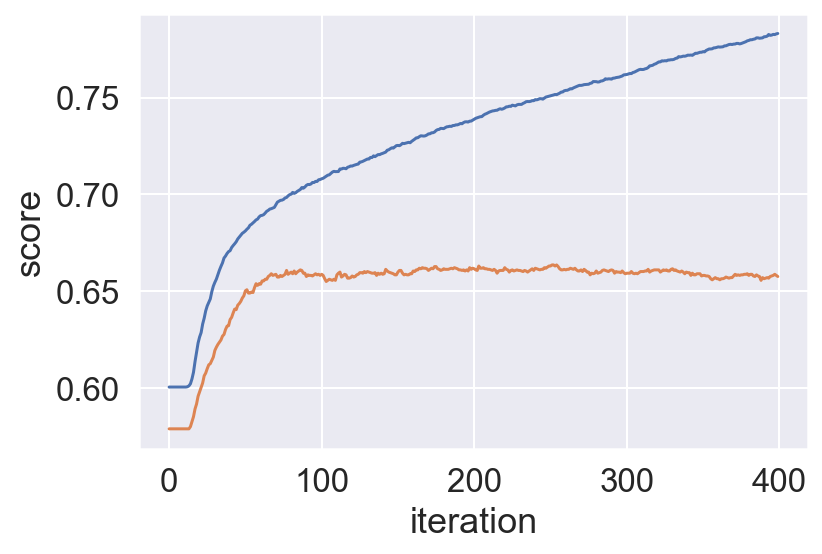

In [32]:
scores_train = pd.DataFrame(gfc_grid.best_estimator_.staged_predict(X_train)).T.apply(
    lambda x: accuracy_score(yC_train,  x), axis=0)
scores_test = pd.DataFrame(gfc_grid.best_estimator_.staged_predict(X_test)).T.apply(
    lambda x: accuracy_score(yC_test, x), axis=0)
print(scores_test.tail())
ax = scores_train.plot()
scores_test.plot(ax=ax)
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

In [22]:
rfc_grid.best_params_

{'criterion': 'entropy'}